In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

# Hands-on Activity 22.1: Gaussian Process Regression Without Noise

## Objectives

+ Perform Gaussian process regression without measurement noise

## References

+ [Chapter 3 from C.E. Rasmussen's textbook on Gaussian processes](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf)

## Example: Gaussian process regression in 1D with fixed hyper-parameters

Let's generate some synthetic 1D data to work with:

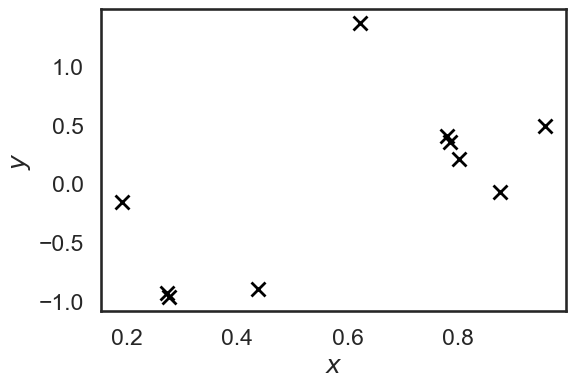

In [2]:
# Fixing the seed so that we all see the same data
np.random.seed(1234)
n = 10
# The inputs are in [0, 1]
X = np.random.rand(n, 1) # Needs to be an n x 1 vector
# The true function that we will try to identify
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
# Some data to train on
Y = f_true(X)
# Let's visualize the data
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [3]:
# Now, we will get started with the regression
# First, import GPy
import GPy
# Second, pick a kernel. Let's pick a squared exponential (RBF = Radial Basis Function)
k = GPy.kern.RBF(1) # The parameter here is the dimension of the input (here 1)
# Let's print the kernel object to see what it includes:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        


The ``variance`` of the kernel is one. This seems reasonable.
Let's leave it like that.
The ``lengthscale`` seems to big.
Let's change it to something reasonable (based on our expectations):

In [4]:
k.lengthscale = 0.1
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.1  |      +ve      |        


There is a possibility to choose a mean function, but for simplicity we are going to pick a zero mean function:
$$
m(x) = 0.
$$
Now we put together the GP regression model as follows:

In [5]:
gpm = GPy.models.GPRegression(X, Y, k) # It is input, output, kernel

This model is automatically assuming that the likelihood is Gaussian (you can modify it if you wish).
Where do can you find the $\sigma^2$ parameter specifying the likelihood noise? Here it is:

In [6]:
print(gpm)


Name : GP regression
Objective : 12.970132493358294
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.1  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


We are now going to fix the measurement noise to zero:

In [7]:
gpm.likelihood.variance = 0.0
print(gpm)


Name : GP regression
Objective : -2.3009139083970465
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.1  |      +ve      |        
  Gaussian_noise.variance  |    0.0  |      +ve      |        


That's it. We have now specified the model completely.
The posterior GP is completely defined.
Where is the posterior mean $m_n(x)$ and variance $\sigma_n^2(x)$? You can get them like this:

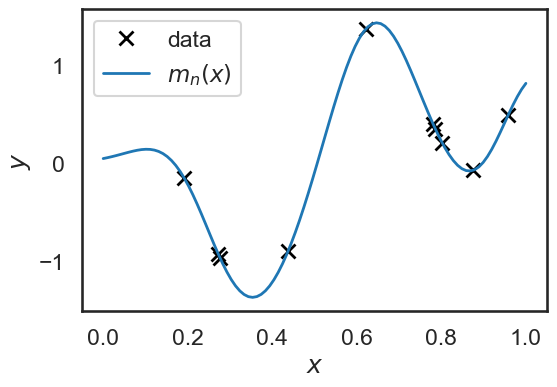

In [8]:
# First the mean on some test points
x_star = np.linspace(0, 1, 100)[:, None] # This is needed to turn the array into a column vector
m_star, v_star = gpm.predict(x_star)
# Let's plot the mean first
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
plt.legend(loc='best');

Now the variance on the same test points is:

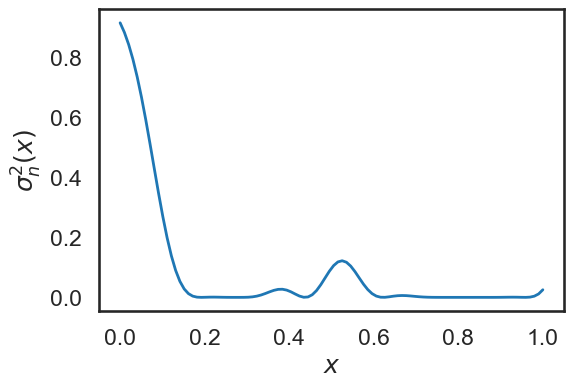

In [9]:
# Now the variance on the same test points
fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, v_star, lw=2, label='$\sigma_n^2(x)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$\sigma_n^2(x)$');

Notice that the variance is zero wherever we have an observation.

Having the posterior mean and variance, we can derive 95\% predictive intervals for $f(x^*)$ and $y^*$.
For $f(x^*)$ these are:
$$
m_n(\mathbf{x}^*)) - 2\sigma_n(\mathbf{x}^*) \le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sigma_n(\mathbf{x}^*).
$$
Let's plot this:

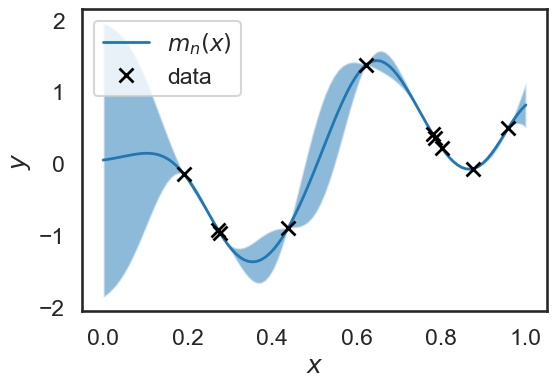

In [10]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5)
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
plt.legend(loc='best');

Let's also put the correct function there for comparison:

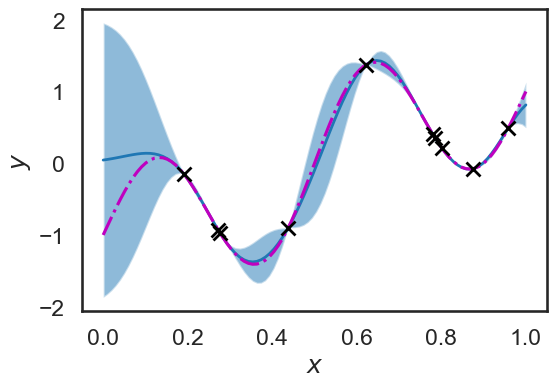

In [11]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
#plt.legend(loc='best');

You see that the true function is almost entirely within the blue bounds.
It is ok that it is a little bit off, becuase these are 95% prediction intervals.
About 5% of the function can be off.

That's good.
However, we have much more information encoded in the posterior GP.
It is actually a probability measure over the space of functions.
How do we sample functions?
Well, you can't sample functions...
They are infinite objects.
But you can sample the *function values* on a bunch of test points.
As a matter of fact, the joint probability density of the function values at any collection of set points is a multivariate Gaussian.
We did it manually in the last lecture.
In this lecture, we are going to use the capabilities of ``GPy``.
Here it is:

In [12]:
# Here is how you take the samples
f_post_samples = gpm.posterior_samples_f(x_star, 10) # Test points, how many samples you want
# Here is the size of f_post_samples
print(f_post_samples.shape)

(100, 1, 10)


This is ``test points x number of outputs (1 here) x number of samples``.
Let's plot them along with the data and the truth:

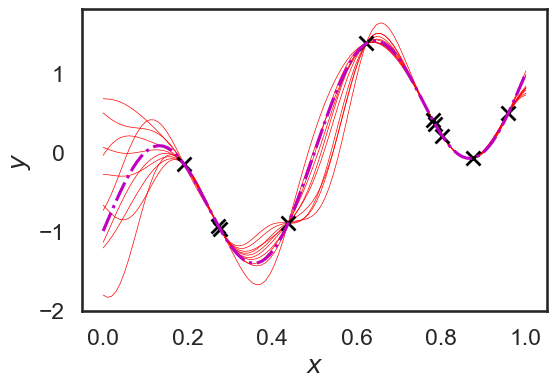

In [13]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Ok, we see that the lengthscale we have assumed does not match the lengthscale of the true function perfectly.
But that's how it is.
In real problems, you won't know the true function anyway. 

The following interactive function regenerates the figures above allowing you to experiment with various choices of the hyperparameters.

In [20]:
from ipywidgets import interact_manual

def analyze_and_plot_gp_ex1(kern_variance=1.0, kern_lengthscale=0.1):
    """
    Performs GP regression with given kernel variance, lengthcale and likelihood variance.
    """
    #k = GPy.kern.RBF(1)
    k = GPy.kern.Matern32(1)
    gp_model = GPy.models.GPRegression(X, Y, k)
    # Set the parameters
    gp_model.kern.variance = kern_variance
    gp_model.kern.lengthscale = kern_lengthscale
    gp_model.likelihood.variance = 0.0
    # Print model for sanity check
    print(gp_model)
    # Pick test points
    x_star = np.linspace(0, 1, 100)[:, None]
    # Get posterior mean and variance
    m_star, v_star = gp_model.predict(x_star)
    # Plot 1: Mean and 95% predictive interval
    fig1, ax1 = plt.subplots()
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    f_lower = m_star - 2.0 * np.sqrt(v_star)
    f_upper = m_star + 2.0 * np.sqrt(v_star)
    ax1.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
    ax1.plot(x_star, m_star, lw=2, label='$m_n(x)$')
    ax1.plot(x_star, f_true(x_star), 'm-.', label='True function')
    ax1.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
    #plt.legend(loc='best');
    
    # Plot 2: Data plus posterior samples
    fig2, ax2 = plt.subplots()
    f_post_samples = gp_model.posterior_samples_f(x_star, 10)
    ax2.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
    ax2.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
    ax2.plot(x_star, f_true(x_star), 'm-.', label='True function')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    #plt.legend(loc='best');
    
interact_manual(analyze_and_plot_gp_ex1,
            kern_variance=(0.01, 10.0, 0.01),
            kern_lengthscale=(0.01, 1.0, 0.01),
            like_variance=(0.01, 1.0, 0.01));

interactive(children=(FloatSlider(value=1.0, description='kern_variance', max=10.0, min=0.01, step=0.01), Floa…

## Diagnostics: How do you know if the fit is good?

To objective test the resulting model we need a *validation dataset* consisting of inputs:
$$
\mathbf{x}^v_{1:n^v} = \left(\mathbf{x}^v_1,\dots,\mathbf{x}^v_{n^v}\right),
$$
and corresponding, observed outputs:
$$
\mathbf{y}^v_{1:n^v} = \left(y^v_1,\dots,y^v_{n^v}\right).
$$
We will use this validation dataset to define some diagnostics.
Let's do it directly through the 1D example above.
First, we generate some validation data:

In [15]:
n_v = 100
X_v = np.random.rand(n_v)[:, None]
Y_v = f_true(X_v)

#### Point-predictions

Point-predictions only use $m_n\left(\mathbf{x}^v_i\right)$.
Of course, when there is a lot of noise, they are not very useful.
But let's look at what we get anyway.
(In the questions section I will ask you to reduce the noise and repeat).

The simplest thing we can do is to compare $y^v_i$ to $m_n\left(\mathbf{x}^v_i\right)$.
We start with the *mean square error*:
$$
\operatorname{MSE} := \frac{1}{n^v}\sum_{i=1}^{n^v}\left[y^v_i-m_n\left(\mathbf{x}^v_i\right)\right]^2.
$$

In [16]:
m_v, v_v = gpm.predict(X_v)
mse = np.mean((Y_v - m_v) ** 2)
print('MSE = {0:1.2f}'.format(mse))

MSE = 0.07


This is not very intuitive though.
An somewhat intuitive measure is [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) also known as $R^2$, *R squared*.
It is defined as:
$$
R^2 = 1 - \frac{\sum_{i=1}^{n^v}\left[y_i^v - m_n(\mathbf{x}_i^v)\right]^2}{\sum_{i=1}^{n^v}\left[y_i^v-\bar{y}^v\right]^2},
$$
where $\bar{y}^v$ is the mean of the observed data:
$$
\bar{y}^v = \frac{1}{n^v}\sum_{i=1}^{n^v}y_i^v.
$$
The interpretation of $R^2$, and take this with a grain of salt, is that it gives the percentage of variance of the data explained by the model.
A score of $R^2=1$, is a perfect fit.
In our data we get:

In [17]:
R2 = 1.0 - np.sum((Y_v - m_v) ** 2) / np.sum((Y_v - np.mean(Y_v)) ** 2)
print('R2 = {0:1.2f}'.format(R2))

R2 = 0.88


Finally, on point-predictions, we can simply plot the predictions vs the observations:

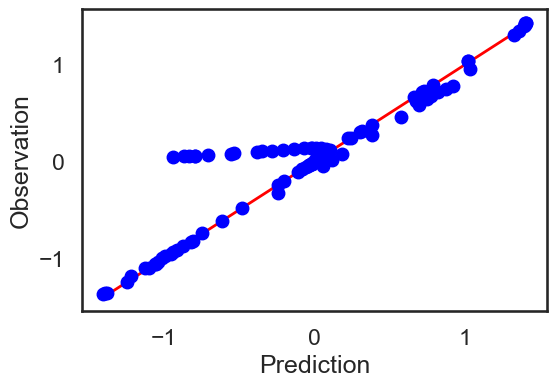

In [18]:
fig, ax = plt.subplots(dpi=100)
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, 'r', lw=2)
ax.plot(Y_v, m_v, 'bo')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation');

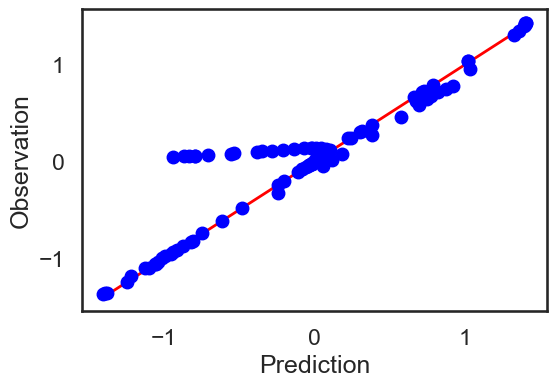

In [19]:
fig, ax = plt.subplots(dpi=100)
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, 'r', lw=2)
ax.plot(Y_v, m_v, 'bo')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation');

### Questions

In the interactive tool above:

+ Experiment with differnet lengthscales for the kernel. You need to click on ``Run Interact`` for the code to run.
What happens to the posterior mean and the 95% predictive error bar as the lengthscale increases (decreases)?

+ Experiment with different kernel variances. This the $s^2$ parameter of the squared exponential covariance function. It specifies our prior variance about the function values. What is its effect?

+ Imagine that, as it would be the case in reality, you do not know the true function. How would you pick the correct values for the hyperparameters specifying the kernel?

+ Try some other kernels. Edit the function ``analyze_and_plot_gp_ex1`` and change the line ``k = GPy.kern.RBF(1)`` to ``k = GPy.kern.Matern52(1)``. This is a kernel that is less regular than the RBF. What do you observe?
Then try ``k = GPy.kern.Matern32(1)``. Then ``k = GPy.kern.Exponential(1)``. The last one is continuous but nowhere differentiable.
How can you pick the right kernel?